# Buisness Problem


# Data Understanding

# Data Preperation

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt

import gzip
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer

import re

import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [42]:
import seaborn as sns

In [2]:
import contractions

In [29]:
from bs4 import BeautifulSoup

In [3]:
import pyLDAvis
import pyLDAvis.gensim_models

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Subsetting data

## Initial Pre-processing

# Data Exploration

## EDA

In [4]:
df = pd.read_csv('data/reviews_subset.csv')

In [5]:
df.head()

,overall,reviewText,verified,asin,brand,title
0,4.0,I bought this lens for my Rebel 2000 camera an...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...
1,4.0,Canon EF Lenses Have A Built In AF Motor..Comp...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...
2,5.0,I bought this lens about six months after repl...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...
3,5.0,Bought this as a replacement and it was worth ...,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...
4,5.0,good,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129592 entries, 0 to 129591
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     129592 non-null  float64
 1   reviewText  129550 non-null  object 
 2   verified    129592 non-null  bool   
 3   asin        129592 non-null  object 
 4   brand       129592 non-null  object 
 5   title       129592 non-null  object 
dtypes: bool(1), float64(1), object(4)
memory usage: 5.1+ MB


In [7]:
df.isna().sum()

overall        0
reviewText    42
verified       0
asin           0
brand          0
title          0
dtype: int64

In [8]:
df.dropna(inplace = True)

In [9]:
df.isna().sum()

overall       0
reviewText    0
verified      0
asin          0
brand         0
title         0
dtype: int64

In [10]:
df.overall.value_counts(normalize = True)

5.0    0.673987
4.0    0.171764
3.0    0.070853
1.0    0.047781
2.0    0.035616
Name: overall, dtype: float64

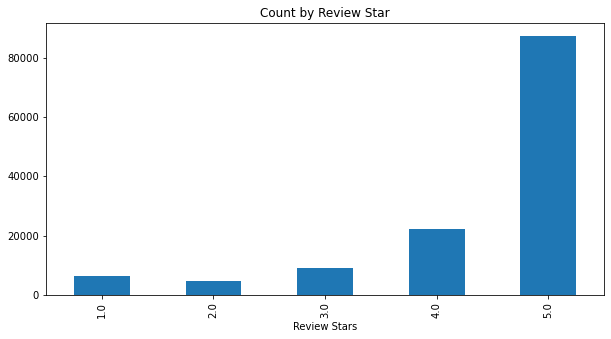

In [6]:
ax = df.overall.value_counts().sort_index().plot(kind = 'bar',
                                            title = 'Count by Review Star',
                                            figsize = (10,5))
ax.set_xlabel('Review Stars');


In [30]:
df.verified.value_counts()

True     119550
False     10042
Name: verified, dtype: int64

<AxesSubplot:xlabel='verified', ylabel='overall'>

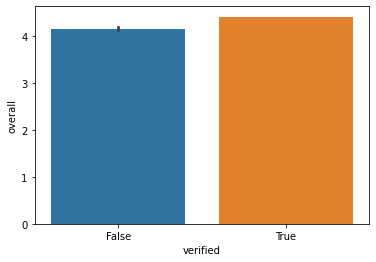

In [29]:
sns.barplot(data = df, x = 'verified', y = 'overall')

In [31]:
df.brand.value_counts()

Canon           13435
Altura Photo     8562
AmazonBasics     7935
Nikon            6616
Case Logic       6133
                ...  
Kastar            311
Sigma             307
SUNPAK            286
Slik              269
Lowepro           258
Name: brand, Length: 66, dtype: int64

In [60]:
dfg = df.groupby('brand')['overall'].mean().sort_values(ascending = False)

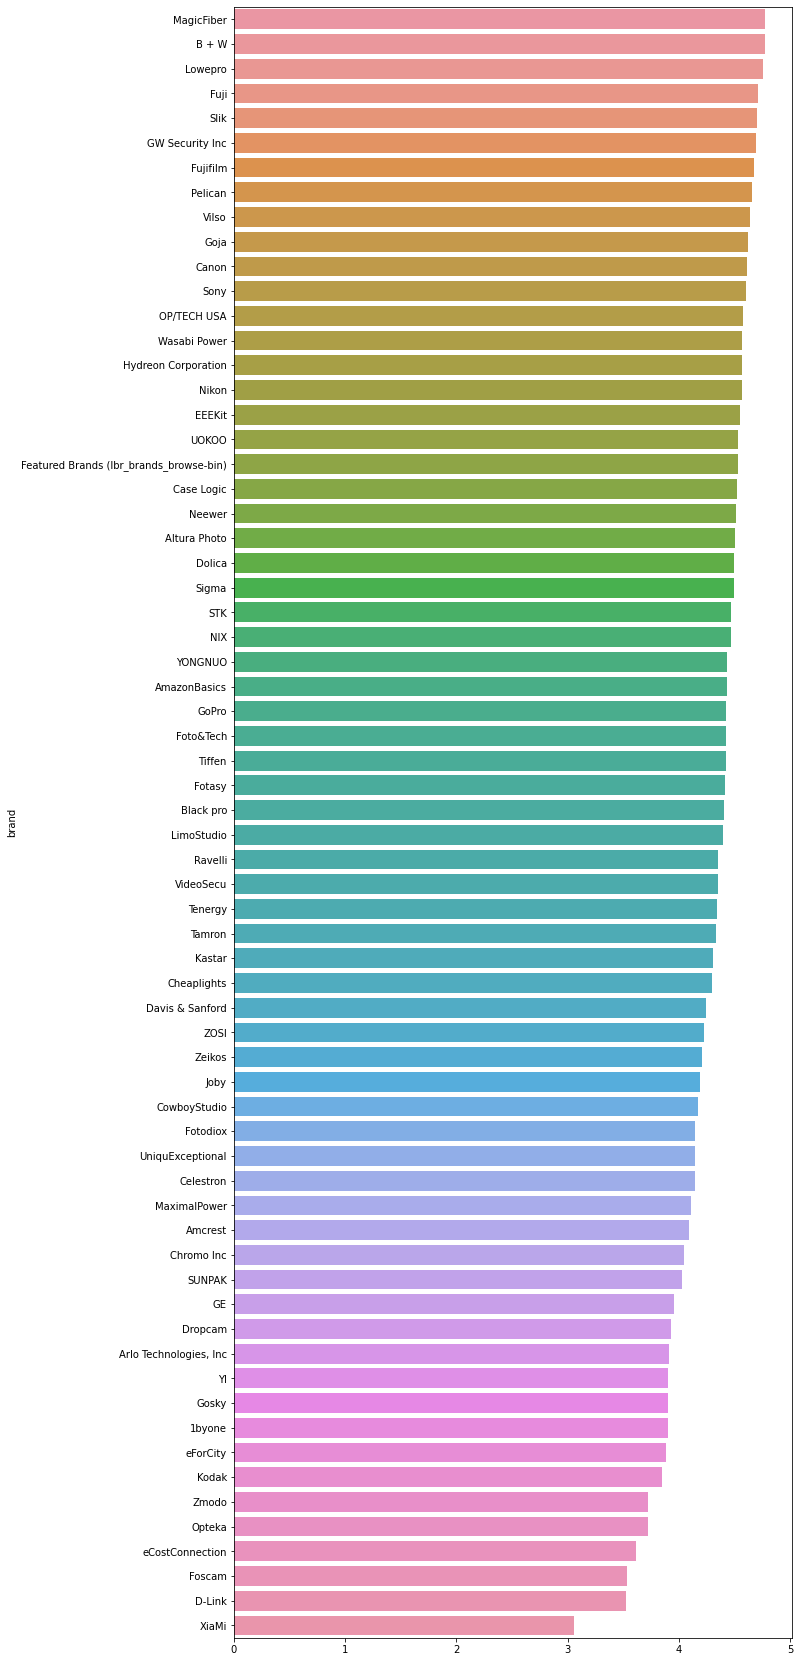

In [61]:
fig, ax = plt.subplots(figsize = (10,30))
ax = sns.barplot(x = dfg.values, y = dfg.index, orient = 'h')

## Sentiment Validation of Star Ratings

In [12]:
sia = SentimentIntensityAnalyzer()

In [11]:
df.reviewText[0]

'I bought this lens for my Rebel 2000 camera and have been very pleased with the results.  I never use autofocus, but the AF feature when I played with it was very fast and accurate.  I got the best pictures by using an all-around 800 Max film with this lens.'

In [12]:
df.overall[0]

4.0

In [13]:
sia.polarity_scores(df.reviewText[0])

{'neg': 0.024, 'neu': 0.774, 'pos': 0.203, 'compound': 0.8933}

In [13]:
sent_val_df = df.copy()

In [17]:
sent_val_df['compound'] = [sia.polarity_scores(str(x))['compound'] for x in df['reviewText']]
sent_val_df['neg'] = [sia.polarity_scores(str(x))['neg'] for x in df['reviewText']]
sent_val_df['neu'] = [sia.polarity_scores(str(x))['neu'] for x in df['reviewText']]
sent_val_df['pos'] = [sia.polarity_scores(str(x))['pos'] for x in df['reviewText']]

In [18]:
sent_val_df.head()

,overall,reviewText,verified,asin,brand,title,compound,neg,neu,pos
0,4.0,I bought this lens for my Rebel 2000 camera an...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,0.8933,0.024,0.774,0.203
1,4.0,Canon EF Lenses Have A Built In AF Motor..Comp...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,0.8979,0.022,0.900,0.078
2,5.0,I bought this lens about six months after repl...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,0.6739,0.078,0.825,0.097
3,5.0,Bought this as a replacement and it was worth ...,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,0.8516,0.000,0.671,0.329
4,5.0,good,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,0.4404,0.000,0.000,1.000


In [24]:
import seaborn as sns

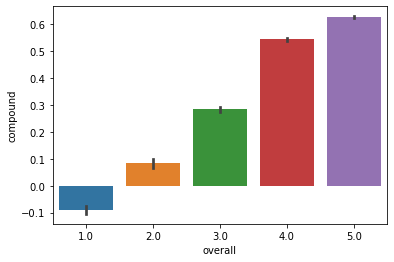

In [25]:
ax = sns.barplot(data = sent_val_df, x = 'overall', y = 'compound')

Text(0.5, 1.0, 'Negative')

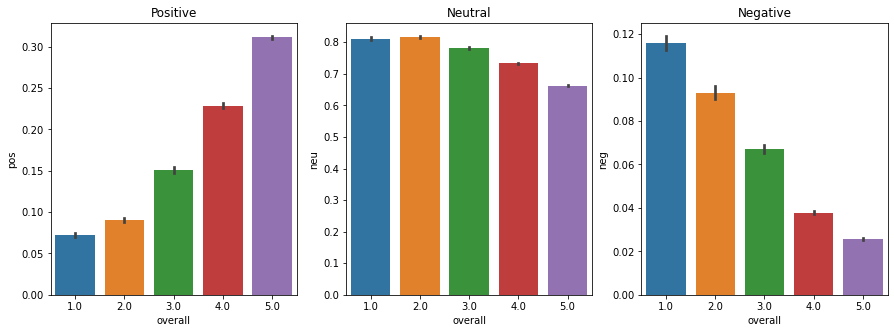

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = sent_val_df, x = 'overall', y = 'pos', ax = axs[0])
sns.barplot(data = sent_val_df, x = 'overall', y = 'neu', ax = axs[1])
sns.barplot(data = sent_val_df, x = 'overall', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative');

In [15]:
def label_encode(x):
    if x <= 3:
        return 0
    if x > 3:
        return 1

In [16]:
df["sentiment"] = df["overall"].apply(lambda x: label_encode(x))

In [17]:
df['sentiment'].value_counts(normalize = True)

1    0.845751
0    0.154249
Name: sentiment, dtype: float64

## Text Pre-processing

In [18]:
def word_count(text):
    return len(word_tokenize(text))

In [19]:
df['word_count'] = df.reviewText.apply(lambda x: word_count(x))

In [20]:
df.head()

,overall,reviewText,verified,asin,brand,title,sentiment,word_count
0,4.0,I bought this lens for my Rebel 2000 camera an...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,54
1,4.0,Canon EF Lenses Have A Built In AF Motor..Comp...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,211
2,5.0,I bought this lens about six months after repl...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,191
3,5.0,Bought this as a replacement and it was worth ...,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,30
4,5.0,good,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,1


In [21]:
text_stats_df = df[['reviewText', 'sentiment', 'word_count']].copy()

In [22]:
text_stats_df.head()

,reviewText,sentiment,word_count
0,I bought this lens for my Rebel 2000 camera an...,1,54
1,Canon EF Lenses Have A Built In AF Motor..Comp...,1,211
2,I bought this lens about six months after repl...,1,191
3,Bought this as a replacement and it was worth ...,1,30
4,good,1,1


<AxesSubplot:xlabel='sentiment'>

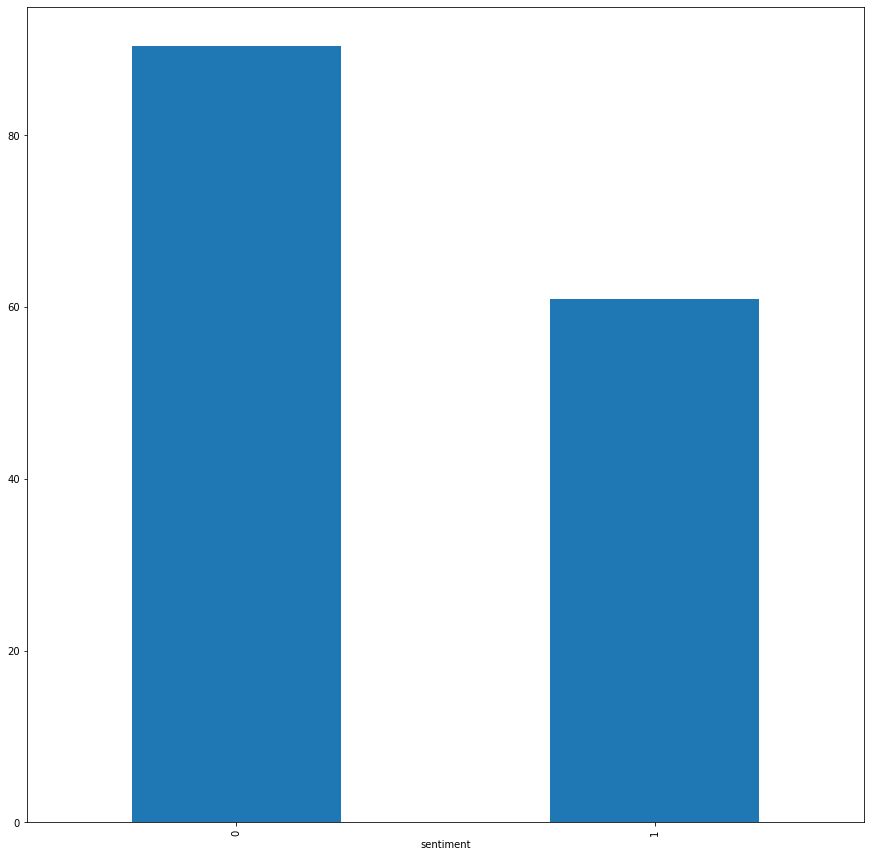

In [39]:
text_stats_df.groupby('sentiment')['word_count'].mean().plot(kind = 'bar', figsize = (15,15))

<AxesSubplot:>

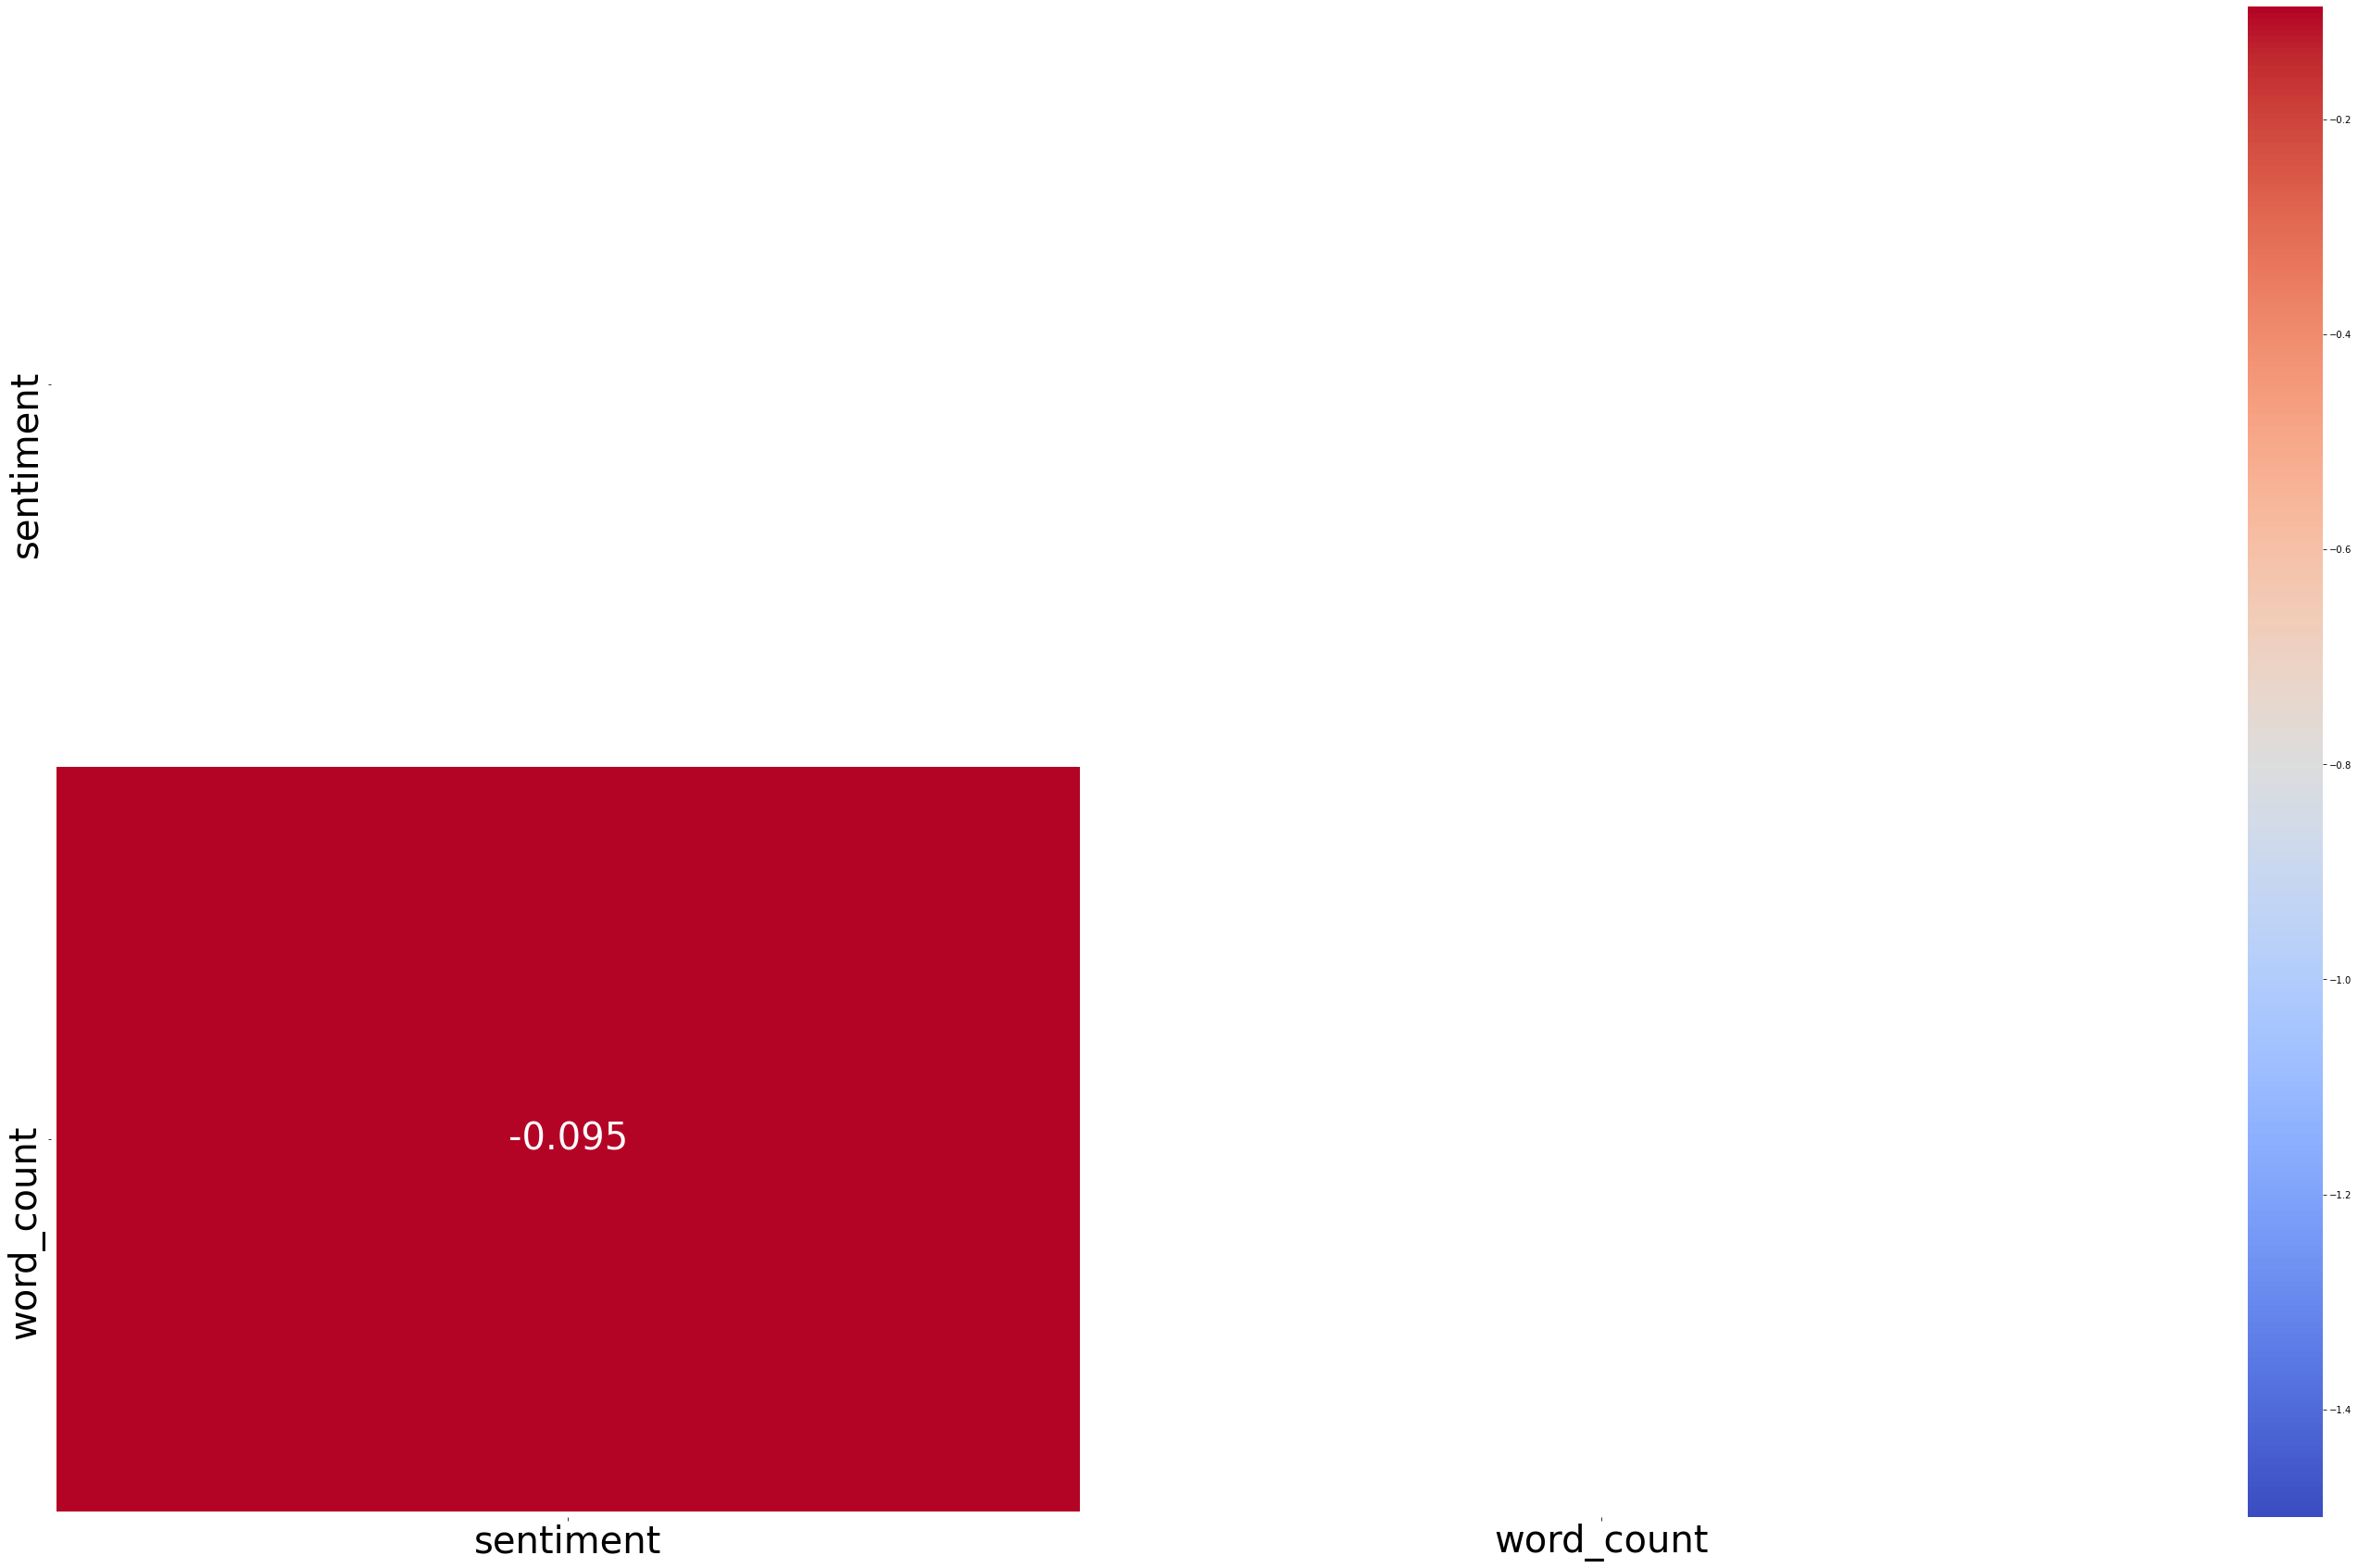

In [43]:
correlation = text_stats_df[['sentiment', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

In [23]:
text_stats_df.describe()

,sentiment,word_count
count,129550.000000,129550.000000
mean,0.845751,65.513192
std,0.361189,112.072947
min,0.000000,1.000000
25%,1.000000,12.000000
50%,1.000000,32.000000
75%,1.000000,73.000000
max,1.000000,4349.000000


<AxesSubplot:>

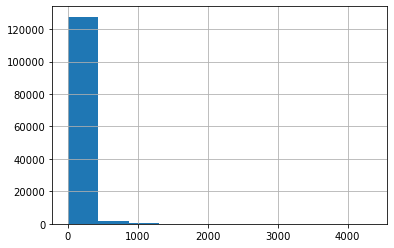

In [24]:
text_stats_df.word_count.hist()

In [25]:
text_stats_df.sort_values(by = 'word_count', ascending = False).head(20)

,reviewText,sentiment,word_count
44098,"=====\nIMPORTANT UPDATE February 9, 2012: It h...",1,4349
47779,==============================================...,1,3118
80879,Before the HD Hero3 I've already owned the ori...,1,3113
100022,Major update:\n\nI made my first long backpack...,1,3038
107916,Living Review meaning that I make updates as t...,0,2989
22782,"To start, I would have to guess that most peop...",0,2914
81037,"GoPro Hero3 Silver Edition\n\nOverall, you mig...",0,2913
38631,I got bit by the bug and decided I needed a ba...,1,2848
74581,EDIT: A problem that I didn't experience at fi...,1,2712
74582,EDIT: A problem that I didn't experience at fi...,1,2712


In [26]:
text_stats_df.sort_values(by = 'word_count', ascending = False).tail(20)

,reviewText,sentiment,word_count
4291,Perfect,1,1
36973,nice,1,1
78491,Okay,0,1
78493,recomended,1,1
58206,GOOOOOOAAAAAALLLLLLL,1,1
118965,Nice,1,1
36982,excellent,1,1
120603,Jeffery,1,1
58186,Okay,1,1
67074,AAA,1,1


In [28]:
text_stats_df.reviewText[44098]

'=====\nIMPORTANT UPDATE February 9, 2012: It has just been announced that Kodak is exiting the digital camera business. Please see Comment #22 for further details.\n=====\n\nThis&nbsp;<a data-hook="product-link-linked" class="a-link-normal" href="/Kodak-PlaySport-HD-Waterproof-Pocket-Video-Camera-Black-NEWEST-MODEL/dp/B0030MITDK/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Kodak PlaySport HD Waterproof Pocket Video Camera (Black) NEWEST MODEL</a>&nbsp;(Model Zx3) video camcorder was offered to me through the Amazon Vine program and, even though I already had a&nbsp;<a data-hook="product-link-linked" class="a-link-normal" href="/Creative-Labs-Vado-HD-Pocket-Video-Camcorder-3rd-Generation-120-Minutes-Black-NEWEST-MODEL/dp/B002P3N1J2/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Creative Labs Vado HD Pocket Video Camcorder 3rd Generation,120 Minutes (Black) - NEWEST MODEL</a>, which I like very much (and received just last month, also through Amazon Vine), I decided to order this Kodak one so I could have a camc

In [30]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    # Remove line breaks and extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

In [138]:
'''
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    # Remove special characters
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    # Join words back into sentence
    text = ' '.join(filtered_text)
    return text
    
'''

In [31]:
text_stats_df['cleaned_text'] = text_stats_df.reviewText.apply(lambda x: clean_text(x))

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [32]:
text_stats_df.head()

,reviewText,sentiment,word_count,cleaned_text
0,I bought this lens for my Rebel 2000 camera an...,1,54,i bought this lens for my rebel 2000 camera an...
1,Canon EF Lenses Have A Built In AF Motor..Comp...,1,211,canon ef lenses have a built in af motorcompar...
2,I bought this lens about six months after repl...,1,191,i bought this lens about six months after repl...
3,Bought this as a replacement and it was worth ...,1,30,bought this as a replacement and it was worth ...
4,good,1,1,good


In [33]:
text_stats_df.cleaned_text[44098]

'important update february 9 2012 it has just been announced that kodak is exiting the digital camera business please see comment 22 for further details  this kodak playsport hd waterproof pocket video camera black newest model model zx3 video camcorder was offered to me through the amazon vine program and even though i already had a creative labs vado hd pocket video camcorder 3rd generation120 minutes black  newest model which i like very much and received just last month also through amazon vine i decided to order this kodak one so i could have a camcorder to use and my wife could have one as well let me state up front that i really like this little camcorder it is small lightweight convenient to slip into a pocket and it is quick and easy to use i think its price is very good also certainly for what you get of course just about the same can be said for the creative vado that said and now that i have both of these camcorders i have to say that it is hard for me to decide which of th

In [34]:
text_stats_df['cleaned_word_count'] = text_stats_df.cleaned_text.apply(lambda x: word_count(x))

In [35]:
text_stats_df.describe()

,sentiment,word_count,cleaned_word_count
count,129550.000000,129550.000000,129550.000000
mean,0.845751,65.513192,57.073068
std,0.361189,112.072947,96.838448
min,0.000000,1.000000,0.000000
25%,1.000000,12.000000,10.000000
50%,1.000000,32.000000,28.000000
75%,1.000000,73.000000,64.000000
max,1.000000,4349.000000,3435.000000


In [38]:
text_stats_df[text_stats_df.cleaned_word_count == 0]

,reviewText,sentiment,word_count,cleaned_text,cleaned_word_count
2861,http://www.amazon.com/gp/product/B00004ZCJL?re...,1,7,,0
3741,:),1,2,,0
6846,:-),1,3,,0
7307,"<div id=""video-block-R2PX631O5HPURN"" class=""a-...",1,57,,0
8645,:),1,2,,0
21917,"<div id=""video-block-R3DCQ06IJNU0M2"" class=""a-...",0,57,,0
27020,:),1,2,,0
29368,http://www.amazon.com/PanaVise-209-Vacuum-Base...,1,3,,0
32995,:),1,2,,0
39569,http://www.amazon.com/gp/product/B004C9PKTG?re...,1,7,,0


In [93]:
cv = CountVectorizer(ngram_range = (3,3), stop_words = stop_words)
words = cv.fit_transform(text_stats_df['cleaned_text'])
sum_words = words.sum(axis=0)
word_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
word_df = pd.DataFrame(word_freq, columns=['word', 'count'])

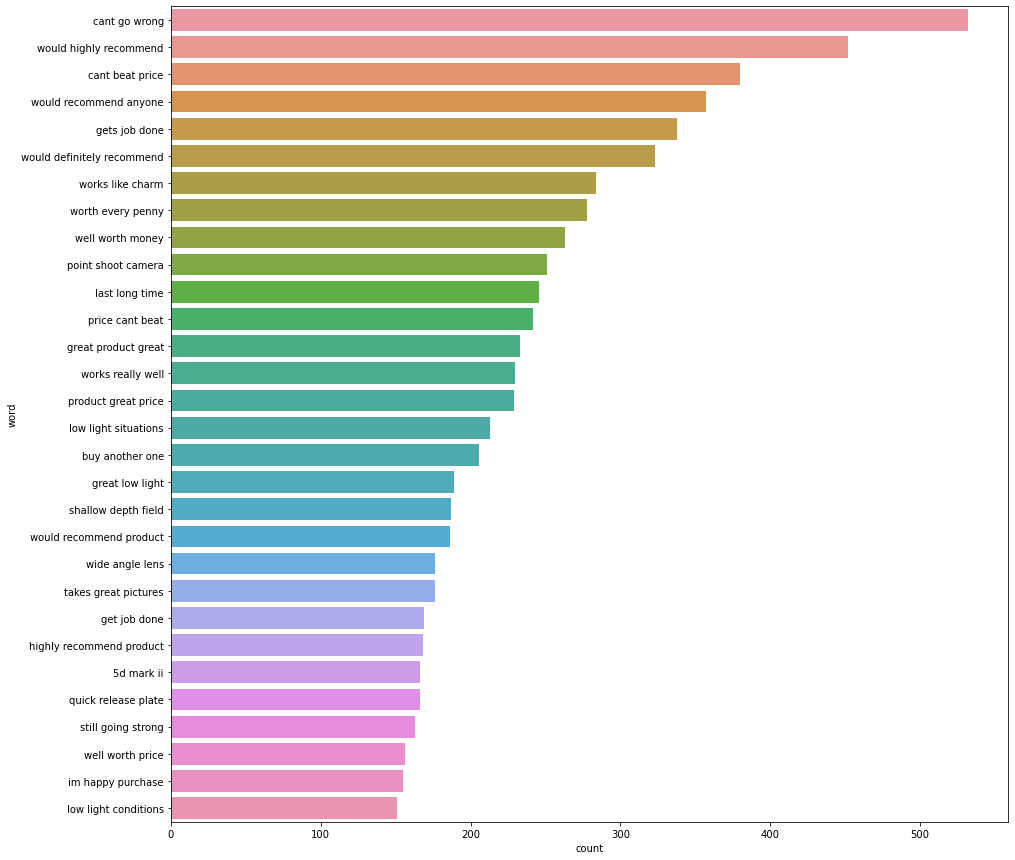

In [94]:
fig, ax = plt.subplots(figsize = (15,15))
ax = sns.barplot(data = word_df.head(30), x = 'count', y = 'word', orient = 'h')

In [56]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [77]:
doc = nlp(text_stats_df.cleaned_text[44098])

In [78]:
def clean_text(doc):
    # Remove stop words, punctuation, and any words that are not alphabetic
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    # Join the tokens back into a string and return it
    return ' '.join(tokens)

In [58]:
cleaned_text = clean_text(doc)

In [79]:
ctext = clean_text(doc)

In [68]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    # Remove line breaks and extra white space
    text = re.sub(r'[\r|\n|\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove stop words and lemmatize text
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.text not in stop_words]
    # Join tokens back into a string
    text = ' '.join(tokens)
    return text

In [83]:
print(nlp.Defaults.stop_words)

{'never', 'neither', 'indeed', "'m", 'used', 'noone', '‘m', 'our', 'seeming', 'her', 'yours', 'against', 'unless', 'who', 'further', 'more', 'nevertheless', 'every', 'whole', 'full', 'be', 'where', 'anyway', 'must', 'bottom', 'can', '‘ve', 'did', '’s', 'still', 're', 'seem', 'may', 'which', 'twenty', 'so', 'his', 'whether', '‘d', 'everyone', 'whereafter', 'in', "'ve", 'into', 'among', 'she', 'your', 'almost', 'how', 'less', 'became', 'perhaps', 'beside', 'him', 'on', 'he', 'were', 'whither', 'empty', 'eight', 'them', 'also', 'using', 'serious', 'hers', 'an', 'that', 'for', 'hence', 'beforehand', 'its', 'between', '’re', 'sometime', "'re", 'upon', 'same', 'whenever', 'other', 'nor', 'it', 'beyond', 'when', 'below', 'something', 'than', 'least', 'get', 'put', 'only', 'please', 'a', 'doing', 'of', 'whom', 'down', 'few', 'besides', 'around', 'toward', 'enough', 'moreover', 'no', 'forty', 'each', 'mostly', 'we', 'see', 'are', 'due', 'hereby', 'have', 'regarding', 'wherein', 'n’t', 'together

In [84]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [65]:
text_stats_df.reviewText[44098]

'=====\nIMPORTANT UPDATE February 9, 2012: It has just been announced that Kodak is exiting the digital camera business. Please see Comment #22 for further details.\n=====\n\nThis&nbsp;<a data-hook="product-link-linked" class="a-link-normal" href="/Kodak-PlaySport-HD-Waterproof-Pocket-Video-Camera-Black-NEWEST-MODEL/dp/B0030MITDK/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Kodak PlaySport HD Waterproof Pocket Video Camera (Black) NEWEST MODEL</a>&nbsp;(Model Zx3) video camcorder was offered to me through the Amazon Vine program and, even though I already had a&nbsp;<a data-hook="product-link-linked" class="a-link-normal" href="/Creative-Labs-Vado-HD-Pocket-Video-Camcorder-3rd-Generation-120-Minutes-Black-NEWEST-MODEL/dp/B002P3N1J2/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Creative Labs Vado HD Pocket Video Camcorder 3rd Generation,120 Minutes (Black) - NEWEST MODEL</a>, which I like very much (and received just last month, also through Amazon Vine), I decided to order this Kodak one so I could have a camc

In [66]:
text_stats_df.cleaned_text[44098]

'important update february 9 2012 it has just been announced that kodak is exiting the digital camera business please see comment 22 for further details  this kodak playsport hd waterproof pocket video camera black newest model model zx3 video camcorder was offered to me through the amazon vine program and even though i already had a creative labs vado hd pocket video camcorder 3rd generation120 minutes black  newest model which i like very much and received just last month also through amazon vine i decided to order this kodak one so i could have a camcorder to use and my wife could have one as well let me state up front that i really like this little camcorder it is small lightweight convenient to slip into a pocket and it is quick and easy to use i think its price is very good also certainly for what you get of course just about the same can be said for the creative vado that said and now that i have both of these camcorders i have to say that it is hard for me to decide which of th

In [82]:
ctext

'important update february announce kodak exit digital camera business comment detail kodak playsport hd waterproof pocket video camera black new model model video camcorder offer amazon vine program creative lab vado hd pocket video camcorder minute black new model like receive month amazon vine decide order kodak camcorder use wife let state like little camcorder small lightweight convenient slip pocket quick easy use think price good certainly course say creative vado say camcorder hard decide prefer small advantage small disadvantage respective feature set example creative vado builtin attach flexible usb connection make transfer video computer easy wish transfer video usb kodak use separate usb cable way supply kodak unit necessary cable video cable etc kodak use separate sdhc card kodak highspeed gb class sdhc flash memory card transferring video snap merely remove card camcorder insert sd slot computer external card reader computer old sd slot note experience video software incl

In [75]:
cleaned_text

'important update february announce kodak exit digital camera business comment detail data link link link normal playsport hd waterproof pocket video camera black newest model dp ref playsport hd waterproof pocket video camera black newest video camcorder offer amazon vine program data link link link normal labs vado hd pocket video minutes black newest model dp ref labs vado hd pocket video camcorder minutes black newest like receive month amazon vine decide order kodak camcorder use wife let state like little camcorder small lightweight convenient slip pocket quick easy use think price good certainly course say creative vado say camcorder hard decide prefer small advantage small disadvantage respective feature set example creative vado build attach flexible usb connection make transfer video computer easy wish transfer video usb kodak use separate usb cable way supply kodak unit necessary cable video cable etc kodak use separate sdhc card datum link link link normal high sdhc flash m

In [76]:
cleaner_text

'  important update february 9 2012 announce kodak exit digital camera business comment 22 detail thisnbspkodak playsport hd waterproof pocket video camera black new modelnbspmodel zx3 video camcorder offer amazon vine program anbspcreative lab vado hd pocket video camcorder 3rd generation120 minute black new model like receive month amazon vine decide order kodak camcorder use wife let state like little camcorder small lightweight convenient slip pocket quick easy use think price good certainly course say creative vado say camcorder hard decide prefer small advantage small disadvantage respective feature set example creative vado builtin attach flexible usb connection make transfer video computer easy wish transfer video usb kodak use separate usb cable way supply kodak unit necessary cable video cable etc kodak use separate sdhc card thisnbspkodak highspeed 16 gb 60x class 4 sdhc flash memory card ksd16ghsbna060 transferring video snap merely remove card camcorder insert sd slot comp

In [71]:
cleaner_text = clean_text(text_stats_df.reviewText[44098])

In [70]:
stop_words = set(stopwords.words('english'))

In [109]:
text_stats_df[text_stats_df.word_count <= 500]

,reviewText,sentiment,word_count,character_count,sentence_count,average_word_length
0,i bought this lens for my rebel 2000 camera an...,1,54,207,3,3.833333
1,canon ef lenses have a built in af motor..comp...,1,211,950,1,4.502370
2,i bought this lens about six months after repl...,1,191,725,9,3.806283
3,bought this as a replacement and it was worth ...,1,30,112,3,3.733333
4,good,1,1,4,1,4.000000
...,...,...,...,...,...,...
129587,i have two original 720 yi home camera that be...,0,26,115,2,4.423077
129588,thanks!,1,2,7,1,3.500000
129589,"first of all, this is similar to, but not a re...",1,256,852,12,3.328125
129590,"after some recent thefts in the neighborhood, ...",1,133,544,5,4.090226


In [110]:
filtered_df = text_stats_df[text_stats_df.word_count <= 500]

In [111]:
filtered_df.describe()

,sentiment,word_count,character_count,sentence_count,average_word_length
count,128195.000000,128195.000000,128195.000000,128195.000000,128195.000000
mean,0.846648,57.769952,221.661695,3.742283,3.940959
std,0.360328,73.602368,284.915250,3.705702,0.760817
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,12.000000,46.000000,1.000000,3.582609
50%,1.000000,32.000000,121.000000,3.000000,3.837838
75%,1.000000,71.000000,271.000000,5.000000,4.129032
max,1.000000,500.000000,2586.000000,39.000000,26.200000


In [112]:
filtered_df.sort_values(by = 'word_count', ascending = False).head(20)

,reviewText,sentiment,word_count,character_count,sentence_count,average_word_length
100276,i bought the four camera 2t hd wifi system. ...,1,500,1881,38,3.766000
107945,i have had my arlo 4-camera system for over a ...,1,500,1908,25,3.820000
24206,i purchased this camera for my wife for christ...,1,500,2061,24,4.122000
36528,"first, let us be clear about what a holster is...",1,499,1959,21,3.925852
36006,i purchased this for use with my nikon d5000. ...,1,499,1890,19,3.787575
43991,i got this camera because it appeared rugged a...,1,499,1946,30,3.899800
128707,these are handy little cameras. i like to leav...,1,499,1879,28,3.769539
13333,i was hesitant to purchase these after reading...,1,499,2100,25,4.212425
103807,bought this camera because it was so cheap. i ...,1,499,1822,26,3.651303
15337,"i am no a professional photographer, but i do ...",0,499,1918,17,3.859719


In [118]:
test = text_stats_df.reviewText[44098]

In [140]:
text_stats_df['cleaned_text'] = text_stats_df['reviewText'].apply(lambda x: clean_text(x))

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
<ipython-input-140-e8d34088f30e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_stats_df['cleaned_text'] = text_stats_df['reviewText'].apply(lambda x: clean_text(x))


In [141]:
text_stats_df.head()

,reviewText,sentiment,word_count,character_count,sentence_count,average_word_length,cleaned_text
0,i bought this lens for my rebel 2000 camera an...,1,54,207,3,3.833333,bought lens rebel 2000 camera pleased results ...
1,canon ef lenses have a built in af motor..comp...,1,211,950,1,4.502370,canon ef lenses built af motorcompared camera ...
2,i bought this lens about six months after repl...,1,191,725,9,3.806283,bought lens six months replacing 20 year old s...
3,bought this as a replacement and it was worth ...,1,30,112,3,3.733333,bought replacement worth money spent less 13 n...
4,good,1,1,4,1,4.000000,good


In [142]:
data = text_stats_df[['sentiment', 'cleaned_text']]

,sentiment,cleaned_text
0,1,bought lens rebel 2000 camera pleased results ...
1,1,canon ef lenses built af motorcompared camera ...
2,1,bought lens six months replacing 20 year old s...
3,1,bought replacement worth money spent less 13 n...
4,1,good


In [144]:
data['word_count'] = data.cleaned_text.apply(lambda x: word_count(x))
data['character_count'] = data.cleaned_text.apply(lambda x: character_count(x))
data['sentence_count'] = data.cleaned_text.apply(lambda x: sentence_count(x))
data['average_word_length'] = data.cleaned_text.apply(lambda x: average_word_length(x))

<ipython-input-144-5af0d3e11dfd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word_count'] = data.cleaned_text.apply(lambda x: word_count(x))
<ipython-input-144-5af0d3e11dfd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['character_count'] = data.cleaned_text.apply(lambda x: character_count(x))
<ipython-input-144-5af0d3e11dfd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

ZeroDivisionError: division by zero

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129550 entries, 0 to 129591
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment        129550 non-null  int64 
 1   cleaned_text     129550 non-null  object
 2   word_count       129550 non-null  int64 
 3   character_count  129550 non-null  int64 
 4   sentence_count   129550 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 10.9+ MB


In [146]:
data.describe()

,sentiment,word_count,character_count,sentence_count
count,129550.000000,129550.000000,129550.000000,129550.000000
mean,0.845751,28.829047,161.832922,0.998804
std,0.361189,48.885221,278.460024,0.034569
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,6.000000,32.000000,1.000000
50%,1.000000,14.000000,80.000000,1.000000
75%,1.000000,32.000000,179.000000,1.000000
max,1.000000,1739.000000,10437.000000,1.000000


In [147]:
data[data.word_count == 0]

,sentiment,cleaned_text,word_count,character_count,sentence_count
909,1,,0,0,0
2727,1,,0,0,0
2861,1,,0,0,0
3588,1,,0,0,0
3741,1,,0,0,0
...,...,...,...,...,...
116654,0,,0,0,0
119284,1,,0,0,0
127630,0,,0,0,0
127947,1,,0,0,0


In [148]:
data.cleaned_text[909]

''

In [159]:
text_stats_df[text_stats_df.word_count == 3].sentiment.value_counts()

1    3436
0     232
Name: sentiment, dtype: int64

In [160]:
test_df = text_stats_df[(text_stats_df.word_count > 3) & (text_stats_df.word_count <= 500)]

In [163]:
test_df.head()

,reviewText,sentiment,word_count,character_count,sentence_count,average_word_length,cleaned_text
0,i bought this lens for my rebel 2000 camera an...,1,54,207,3,3.833333,bought lens rebel 2000 camera pleased results ...
1,canon ef lenses have a built in af motor..comp...,1,211,950,1,4.502370,canon ef lenses built af motorcompared camera ...
2,i bought this lens about six months after repl...,1,191,725,9,3.806283,bought lens six months replacing 20 year old s...
3,bought this as a replacement and it was worth ...,1,30,112,3,3.733333,bought replacement worth money spent less 13 n...
5,good for starters.,1,4,16,1,4.000000,good starters


In [169]:
data = test_df[['reviewText', 'sentiment', 'cleaned_text']]

In [173]:
data

,reviewText,sentiment,cleaned_text,word_count,character_count,sentence_count
0,i bought this lens for my rebel 2000 camera an...,1,bought lens rebel 2000 camera pleased results ...,24,126,1
1,canon ef lenses have a built in af motor..comp...,1,canon ef lenses built af motorcompared camera ...,107,718,1
2,i bought this lens about six months after repl...,1,bought lens six months replacing 20 year old s...,85,472,1
3,bought this as a replacement and it was worth ...,1,bought replacement worth money spent less 13 n...,14,73,1
5,good for starters.,1,good starters,2,12,1
...,...,...,...,...,...,...
129586,"camera works well, just crying detection featu...",0,camera works well crying detection feature fai...,17,92,1
129587,i have two original 720 yi home camera that be...,0,two original 720 yi home camera working incred...,17,92,1
129589,"first of all, this is similar to, but not a re...",1,first similar rebranded nest cam side side nes...,105,495,1
129590,"after some recent thefts in the neighborhood, ...",1,recent thefts neighborhood bought couple yi ca...,55,340,1


In [171]:
data['word_count'] = data.cleaned_text.apply(lambda x: word_count(x))
data['character_count'] = data.cleaned_text.apply(lambda x: character_count(x))
data['sentence_count'] = data.cleaned_text.apply(lambda x: sentence_count(x))
data['average_word_length'] = data.cleaned_text.apply(lambda x: average_word_length(x))

<ipython-input-171-5af0d3e11dfd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word_count'] = data.cleaned_text.apply(lambda x: word_count(x))
<ipython-input-171-5af0d3e11dfd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['character_count'] = data.cleaned_text.apply(lambda x: character_count(x))
<ipython-input-171-5af0d3e11dfd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

ZeroDivisionError: division by zero

In [172]:
data.describe()

,sentiment,word_count,character_count,sentence_count
count,116411.000000,116411.000000,116411.000000,116411.000000
mean,0.837352,27.876996,156.177243,0.999845
std,0.369046,32.617225,185.001153,0.012434
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,8.000000,44.000000,1.000000
50%,1.000000,16.000000,90.000000,1.000000
75%,1.000000,34.000000,190.000000,1.000000
max,1.000000,260.000000,1777.000000,1.000000


In [176]:
data_fil = data[data.word_count > 0]

In [178]:
data_fil.describe()

,sentiment,word_count,character_count,sentence_count
count,116393.000000,116393.000000,116393.000000,116393.0
mean,0.837344,27.881307,156.201395,1.0
std,0.369053,32.617905,185.005262,0.0
min,0.000000,1.000000,2.000000,1.0
25%,1.000000,8.000000,44.000000,1.0
50%,1.000000,16.000000,90.000000,1.0
75%,1.000000,34.000000,190.000000,1.0
max,1.000000,260.000000,1777.000000,1.0


<AxesSubplot:>

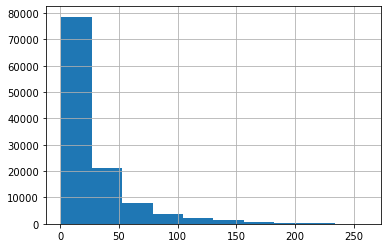

In [179]:
data_fil.word_count.hist()

In [183]:
df2 = data[data.word_count < 100]

In [184]:
df2.describe()

,sentiment,word_count,character_count,sentence_count
count,111030.000000,111030.000000,111030.000000,111030.000000
mean,0.841475,22.439125,125.370098,0.999838
std,0.365234,20.591092,116.306831,0.012732
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,8.000000,42.000000,1.000000
50%,1.000000,15.000000,85.000000,1.000000
75%,1.000000,30.000000,168.000000,1.000000
max,1.000000,99.000000,698.000000,1.000000


<AxesSubplot:>

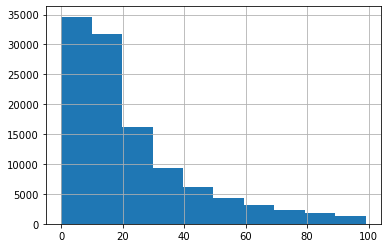

In [185]:
df2.word_count.hist()

In [186]:
df2.head()

,reviewText,sentiment,cleaned_text,word_count,character_count,sentence_count
0,i bought this lens for my rebel 2000 camera an...,1,bought lens rebel 2000 camera pleased results ...,24,126,1
2,i bought this lens about six months after repl...,1,bought lens six months replacing 20 year old s...,85,472,1
3,bought this as a replacement and it was worth ...,1,bought replacement worth money spent less 13 n...,14,73,1
5,good for starters.,1,good starters,2,12,1
6,just like new...,1,like new,2,7,1


In [187]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

In [190]:
data_words = gen_words(df2.cleaned_text)

In [191]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [192]:
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [193]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='symmetric',
                                           per_word_topics=True)

In [194]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.246422  0.025203       1        1  21.665991
5     -0.192337 -0.017899       2        1  20.952092
3     -0.105019  0.046620       3        1  18.622921
1      0.023315 -0.032631       4        1  16.562907
0      0.237636 -0.319684       5        1  11.535674
4      0.282828  0.298391       6        1  10.660416, topic_info=           Term          Freq         Total Category  logprob  loglift
107     quality  33224.000000  33224.000000  Default  30.0000  30.0000
574         set  21740.000000  21740.000000  Default  29.0000  29.0000
47        great  45497.000000  45497.000000  Default  28.0000  28.0000
97        price  24310.000000  24310.000000  Default  27.0000  27.0000
92         good  36573.000000  36573.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
495   impressed   1731.293174   1732.105814   Topic6  -5.0070   2.2382
1933      cable   1583.844168   1584.655659   Topic6  -5.0960   2.2381
2747         ir   1563.061903   1563.878020   Topic6  -5.1092   2.2381
278         two   3647.441408   7320.895625   Topic6  -4.2618   1.5419
6        camera   6129.522586  48443.284602   Topic6  -3.7427   0.1714

[301 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
169        5  0.999358  ability
170        3  0.305783     able
170        4  0.592401     able
170        5  0.000215     able
170        6  0.101425     able
...      ...       ...      ...
27590      5  0.307278       yi
27590      6  0.005367       yi
15351      1  0.006796    zmodo
15351      4  0.873770    zmodo
15351      5  0.118938    zmodo

[353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 4, 2, 1, 5])